In [1]:
%matplotlib inline

# Model Training
Code for finding the best predictive model   
_Author: Jimmy Charité_  
_Email: jimmy.charite@gmail.com_  
_Date: January 8, 2017_

### Directory & Initial Packages

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from IPython.display import Image
from IPython.core.display import HTML

The default directory is the code subdirectory. Changing to the main repo directory above.

### Upload Data

In [3]:
retval=os.chdir("..")

In [4]:
clean_data=pd.read_csv("./clean_data/modeling_data.csv")
clean_data.head()

,height_0t50,height_100t150,height_150t200,height_200t250,height_250t300,height_300t350,height_350t400,height_400t,height_50t100,width_0t50,...,caption*home,caption*my,caption*your,caption*in,caption*bytes,caption*here,caption*click,caption*for,caption*you,image_type
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,1


### Random States

In [5]:
my_rand_state=0

### Training and Testing Split

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X = (clean_data.iloc[:,:-1]).as_matrix()
y = (clean_data.iloc[:,-1]).tolist()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                              random_state=my_rand_state)

### Class Imbalance Corrections

In [9]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

/home/jim/anaconda2/envs/py35/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [77]:
ros = RandomOverSampler(random_state=my_rand_state)
smote = SMOTE(random_state=my_rand_state)
rus = RandomUnderSampler(random_state=my_rand_state)
tl = TomekLinks(random_state=my_rand_state)

### Feature Selection

In [11]:
from sklearn.feature_selection import VarianceThreshold

In [12]:
vt = VarianceThreshold()
threshold=[p*(1-p) for p in [0, 0.05, 0.1, 0.15]]

Note, since the formula for the variance of binary variables is p*(1-p), where p is the proportion of times that the binary variable is 1, I use the proportion to define the variance thresholds. The max variance is 0.25 at p=0.5.

### Classification Models

In [15]:
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

Although tuning is not necessary for Naive Bayes, I pass the default parameters of those models to GridSearchCV anyway so that I can do a direct pair-wise comparison with the other models across the different steps of the cross-validation.

In the interest of time, I didn't use the SVM classifier to avoid lengthy model training time.

I use a training set to tune the model's hyperparameters and a test set to evaluate them. With more time and data, I would use repeated nested cross-validation to get a create a more robust model tuning, selection, and performance assessment workflow. 

In [16]:
nb_clf=GaussianNB()
priors=[None]

In [35]:
qda_clf=QuadraticDiscriminantAnalysis()
reg_param=[0.0, 0.25, 0.5, 0.75]

In [38]:
log_clf=LogisticRegression()
C=[0.001 , 0.01, 10, 100,1000]

In [53]:
knn_clf=KNeighborsClassifier(n_jobs=4)
n_neighbors=list(range(1,17,2))
weights=['uniform','distance']

In [287]:
rf_clf=RandomForestClassifier()
n_estimators=[100]
max_features=[.1,.3,.5]

In [23]:
class_weight=['balanced']
class_weight.extend([{1: w} for w in [1, 2, 10]])

### Creating Pipelines

In [24]:
from imblearn import pipeline #needed if blending imblearn with sklearn classes
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [25]:
n_jobs=4

In [26]:
n_folds=10
skfold = StratifiedKFold(n_splits=n_folds,random_state=my_rand_state, shuffle=False)

#### Naive Bayes Estimators

In [30]:
nb_clf_b = pipeline.Pipeline(steps=[('vt',vt),('clf',nb_clf)])
nb_clf_est_b = GridSearchCV(estimator=nb_clf_b,cv=skfold,
              scoring='roc_auc',n_jobs=n_jobs,
              param_grid=dict(vt__threshold=threshold,clf__priors=priors))

In [75]:
nb_clf_ros = pipeline.Pipeline(steps=[('ros',ros),('vt',vt),
                                      ('clf',nb_clf)])
nb_clf_est_ros = GridSearchCV(estimator=nb_clf_ros,cv=skfold,
              scoring='roc_auc',n_jobs=n_jobs,
              param_grid=dict(vt__threshold=threshold,
                              clf__priors=priors))

In [76]:
nb_clf_smote = pipeline.Pipeline(steps=[('smote',smote),('vt',vt),
                                      ('clf',nb_clf)])
nb_clf_est_smote = GridSearchCV(estimator=nb_clf_smote,cv=skfold,
              scoring='roc_auc',n_jobs=n_jobs,
              param_grid=dict(vt__threshold=threshold,
                              clf__priors=priors))

In [78]:
nb_clf_rus = pipeline.Pipeline(steps=[('rus',rus),('vt',vt),
                                      ('clf',nb_clf)])
nb_clf_est_rus = GridSearchCV(estimator=nb_clf_rus,cv=skfold,
              scoring='roc_auc',n_jobs=n_jobs,
              param_grid=dict(vt__threshold=threshold,
                              clf__priors=priors))

In [79]:
nb_clf_tl = pipeline.Pipeline(steps=[('tl',tl),('vt',vt),
                                      ('clf',nb_clf)])
nb_clf_est_tl = GridSearchCV(estimator=nb_clf_tl,cv=skfold,
              scoring='roc_auc',n_jobs=n_jobs,
              param_grid=dict(vt__threshold=threshold,
                              clf__priors=priors))

#### QDA Estimators

In [32]:
qda_clf_b = pipeline.Pipeline(steps=[('vt',vt),('clf',qda_clf)])
qda_clf_est_b = GridSearchCV(estimator=qda_clf_b,cv=skfold,
              scoring='roc_auc',n_jobs=n_jobs,
              param_grid=dict(vt__threshold=threshold,clf__reg_param=reg_param))

In [80]:
qda_clf_ros = pipeline.Pipeline(steps=[('ros',ros),('vt',vt),
                                       ('clf',qda_clf)])
qda_clf_est_ros = GridSearchCV(estimator=qda_clf_ros,cv=skfold,
              scoring='roc_auc',n_jobs=n_jobs,
              param_grid=dict(vt__threshold=threshold,
                              clf__reg_param=reg_param))

In [81]:
qda_clf_smote = pipeline.Pipeline(steps=[('smote',smote),('vt',vt),
                                       ('clf',qda_clf)])
qda_clf_est_smote = GridSearchCV(estimator=qda_clf_smote,cv=skfold,
              scoring='roc_auc',n_jobs=n_jobs,
              param_grid=dict(vt__threshold=threshold,
                              clf__reg_param=reg_param))

In [137]:
qda_clf_rus = pipeline.Pipeline(steps=[('rus',rus),('vt',vt),
                                       ('clf',qda_clf)])
qda_clf_est_rus = GridSearchCV(estimator=qda_clf_rus,cv=skfold,
              scoring='roc_auc',n_jobs=n_jobs,
              param_grid=dict(vt__threshold=threshold,
                              clf__reg_param=reg_param))

In [83]:
qda_clf_tl = pipeline.Pipeline(steps=[('tl',tl),('vt',vt),
                                       ('clf',qda_clf)])
qda_clf_est_tl = GridSearchCV(estimator=qda_clf_tl,cv=skfold,
              scoring='roc_auc',n_jobs=n_jobs,
              param_grid=dict(vt__threshold=threshold,
                              clf__reg_param=reg_param))

#### Logistic Estimators

In [51]:
log_clf_b = pipeline.Pipeline(steps=[('vt',vt),('clf',log_clf)])
log_clf_est_b = GridSearchCV(estimator=log_clf_b,cv=skfold,
              scoring='roc_auc',n_jobs=n_jobs,
              param_grid=dict(vt__threshold=threshold,clf__C=C,
              clf__class_weight=class_weight))

In [105]:
log_clf_ros = pipeline.Pipeline(steps=[('ros',ros),('vt',vt),
                                     ('clf',log_clf)])
log_clf_est_ros = GridSearchCV(estimator=log_clf_ros,cv=skfold,
              scoring='roc_auc',n_jobs=n_jobs,
              param_grid=dict(vt__threshold=threshold,clf__C=C,
              clf__class_weight=class_weight))

In [106]:
log_clf_smote = pipeline.Pipeline(steps=[('smote',smote),('vt',vt),
                                     ('clf',log_clf)])
log_clf_est_smote = GridSearchCV(estimator=log_clf_smote,cv=skfold,
              scoring='roc_auc',n_jobs=n_jobs,
              param_grid=dict(vt__threshold=threshold,clf__C=C,
              clf__class_weight=class_weight))

In [107]:
log_clf_rus = pipeline.Pipeline(steps=[('rus',rus),('vt',vt),
                                     ('clf',log_clf)])
log_clf_est_rus = GridSearchCV(estimator=log_clf_rus,cv=skfold,
              scoring='roc_auc',n_jobs=n_jobs,
              param_grid=dict(vt__threshold=threshold,clf__C=C,
              clf__class_weight=class_weight))

In [399]:
log_clf_tl = pipeline.Pipeline(steps=[('tl',tl),('vt',vt),
                                     ('clf',log_clf)])
log_clf_est_tl = GridSearchCV(estimator=log_clf_tl,cv=skfold,
              scoring='roc_auc',n_jobs=n_jobs,
              param_grid=dict(vt__threshold=threshold,clf__C=C,
              clf__class_weight=class_weight))

#### KNN Estimators

In [42]:
knn_clf_b = pipeline.Pipeline(steps=[('vt',vt),('clf',knn_clf)])
knn_clf_est_b = GridSearchCV(estimator=knn_clf_b,cv=skfold,
              scoring='roc_auc',n_jobs=n_jobs,
              param_grid=dict(vt__threshold=threshold,
              clf__n_neighbors=n_neighbors,
              clf__weights=weights))

In [109]:
knn_clf_ros = pipeline.Pipeline(steps=[('ros',ros),('vt',vt),
                                     ('clf',knn_clf)])
knn_clf_est_ros = GridSearchCV(estimator=knn_clf_ros,cv=skfold,
              scoring='roc_auc',n_jobs=n_jobs,
              param_grid=dict(vt__threshold=threshold,
              clf__n_neighbors=n_neighbors,
              clf__weights=weights))

In [110]:
knn_clf_smote = pipeline.Pipeline(steps=[('smote',smote),('vt',vt),
                                     ('clf',knn_clf)])
knn_clf_est_smote = GridSearchCV(estimator=knn_clf_smote,cv=skfold,
              scoring='roc_auc',n_jobs=n_jobs,
              param_grid=dict(vt__threshold=threshold,
              clf__n_neighbors=n_neighbors,
              clf__weights=weights))

In [111]:
knn_clf_rus = pipeline.Pipeline(steps=[('rus',rus),('vt',vt),
                                     ('clf',knn_clf)])
knn_clf_est_rus = GridSearchCV(estimator=knn_clf_rus,cv=skfold,
              scoring='roc_auc',n_jobs=n_jobs,
              param_grid=dict(vt__threshold=threshold,
              clf__n_neighbors=n_neighbors,
              clf__weights=weights))

In [112]:
knn_clf_tl = pipeline.Pipeline(steps=[('tl',tl),('vt',vt),
                                     ('clf',knn_clf)])
knn_clf_est_tl = GridSearchCV(estimator=knn_clf_tl,cv=skfold,
              scoring='roc_auc',n_jobs=n_jobs,
              param_grid=dict(vt__threshold=threshold,
              clf__n_neighbors=n_neighbors,
              clf__weights=weights))

#### Random Forest Estimators

In [288]:
rf_clf_b = pipeline.Pipeline(steps=[('vt',vt),('clf',rf_clf)])
rf_clf_est_b = GridSearchCV(estimator=rf_clf_b,cv=skfold,
              scoring='roc_auc',n_jobs=n_jobs,
              param_grid=dict(vt__threshold=threshold,
              clf__n_estimators=n_estimators,
              clf__max_features=max_features,
              clf__class_weight=class_weight))

In [289]:
rf_clf_ros = pipeline.Pipeline(steps=[('ros',ros),('vt',vt),
                                    ('clf',rf_clf)])
rf_clf_est_ros = GridSearchCV(estimator=rf_clf_ros,cv=skfold,
              scoring='roc_auc',n_jobs=n_jobs,
              param_grid=dict(vt__threshold=threshold,
              clf__n_estimators=n_estimators,
              clf__max_features=max_features,
              clf__class_weight=class_weight))

In [290]:
rf_clf_smote = pipeline.Pipeline(steps=[('smote',smote),('vt',vt),
                                    ('clf',rf_clf)])
rf_clf_est_smote = GridSearchCV(estimator=rf_clf_smote,cv=skfold,
              scoring='roc_auc',n_jobs=n_jobs,
              param_grid=dict(vt__threshold=threshold,
              clf__n_estimators=n_estimators,
              clf__max_features=max_features,
              clf__class_weight=class_weight))

In [291]:
rf_clf_rus = pipeline.Pipeline(steps=[('rus',rus),('vt',vt),
                                    ('clf',rf_clf)])
rf_clf_est_rus = GridSearchCV(estimator=rf_clf_rus,cv=skfold,
              scoring='roc_auc',n_jobs=n_jobs,
              param_grid=dict(vt__threshold=threshold,
              clf__n_estimators=n_estimators,
              clf__max_features=max_features,
              clf__class_weight=class_weight))

In [292]:
rf_clf_tl = pipeline.Pipeline(steps=[('tl',tl),('vt',vt),
                                    ('clf',rf_clf)])
rf_clf_est_tl = GridSearchCV(estimator=rf_clf_tl,cv=skfold,
              scoring='roc_auc',n_jobs=n_jobs,
              param_grid=dict(vt__threshold=threshold,
              clf__n_estimators=n_estimators,
              clf__max_features=max_features,
              clf__class_weight=class_weight))

### Fitting Estimators

In [92]:
from sklearn.externals import joblib

#### Basic Estimators

#### Naive Bayes Estimators

In [31]:
nb_clf_est_b.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=False),
       error_score='raise',
       estimator=Pipeline(steps=[('vt', VarianceThreshold(threshold=0.0)), ('clf', GaussianNB(priors=None))]),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'vt__threshold': [0, 0.0475, 0.09000000000000001, 0.1275], 'clf__priors': [None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [93]:
joblib.dump(nb_clf_est_b, './other_output/nb_clf_est_b.pkl')

['./other_output/nb_clf_est_b.pkl']

In [84]:
nb_clf_est_ros.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=False),
       error_score='raise',
       estimator=Pipeline(steps=[('ros', RandomOverSampler(random_state=0, ratio='auto')), ('vt', VarianceThreshold(threshold=0.0)), ('clf', GaussianNB(priors=None))]),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'vt__threshold': [0, 0.0475, 0.09000000000000001, 0.1275], 'clf__priors': [None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [94]:
joblib.dump(nb_clf_est_ros, './other_output/nb_clf_est_ros.pkl')

['./other_output/nb_clf_est_ros.pkl']

In [85]:
nb_clf_est_smote.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=False),
       error_score='raise',
       estimator=Pipeline(steps=[('smote', SMOTE(k=5, kind='regular', m=10, n_jobs=-1, out_step=0.5, random_state=0,
   ratio='auto')), ('vt', VarianceThreshold(threshold=0.0)), ('clf', GaussianNB(priors=None))]),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'vt__threshold': [0, 0.0475, 0.09000000000000001, 0.1275], 'clf__priors': [None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [95]:
joblib.dump(nb_clf_est_smote, './other_output/nb_clf_est_smote.pkl')

['./other_output/nb_clf_est_smote.pkl']

In [86]:
nb_clf_est_rus.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=False),
       error_score='raise',
       estimator=Pipeline(steps=[('rus', RandomUnderSampler(random_state=0, ratio='auto', replacement=True,
          return_indices=False)), ('vt', VarianceThreshold(threshold=0.0)), ('clf', GaussianNB(priors=None))]),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'vt__threshold': [0, 0.0475, 0.09000000000000001, 0.1275], 'clf__priors': [None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [96]:
joblib.dump(nb_clf_est_rus, './other_output/nb_clf_est_rus.pkl')

['./other_output/nb_clf_est_rus.pkl']

In [87]:
nb_clf_est_tl.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=False),
       error_score='raise',
       estimator=Pipeline(steps=[('tl', TomekLinks(n_jobs=-1, random_state=0, return_indices=False)), ('vt', VarianceThreshold(threshold=0.0)), ('clf', GaussianNB(priors=None))]),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'vt__threshold': [0, 0.0475, 0.09000000000000001, 0.1275], 'clf__priors': [None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [97]:
joblib.dump(nb_clf_est_tl, './other_output/nb_clf_est_tl.pkl')

['./other_output/nb_clf_est_tl.pkl']

#### QDA Estimators

In [ ]:
qda_clf_est_b.fit(X_train,y_train)

In [98]:
joblib.dump(qda_clf_est_b, './other_output/qda_clf_est_b.pkl')

['./other_output/qda_clf_est_b.pkl']

In [ ]:
qda_clf_est_ros.fit(X_train,y_train)

In [99]:
joblib.dump(qda_clf_est_ros, './other_output/qda_clf_est_ros.pkl')

['./other_output/qda_clf_est_ros.pkl']

In [ ]:
qda_clf_est_smote.fit(X_train,y_train)

In [100]:
joblib.dump(qda_clf_est_smote, './other_output/qda_clf_est_smote.pkl')

['./other_output/qda_clf_est_smote.pkl']

In [ ]:
qda_clf_est_rus.fit(X_train,y_train)

In [139]:
joblib.dump(qda_clf_est_rus, './other_output/qda_clf_est_rus.pkl')

['./other_output/qda_clf_est_rus.pkl']

In [ ]:
qda_clf_est_tl.fit(X_train,y_train)

In [102]:
joblib.dump(qda_clf_est_tl, './other_output/qda_clf_est_tl.pkl')

['./other_output/qda_clf_est_tl.pkl']

#### Logistic Estimators

In [52]:
log_clf_est_b.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=False),
       error_score='raise',
       estimator=Pipeline(steps=[('vt', VarianceThreshold(threshold=0.0)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'clf__class_weight': ['balanced', {1: 1}, {1: 2}, {1: 10}], 'clf__C': [0.001, 0.01, 10, 100, 1000], 'vt__threshold': [0, 0.0475, 0.09000000000000001, 0.1275]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [103]:
joblib.dump(log_clf_est_b, './other_output/log_clf_est_b.pkl')

['./other_output/log_clf_est_b.pkl']

In [121]:
log_clf_est_ros.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=False),
       error_score='raise',
       estimator=Pipeline(steps=[('ros', RandomOverSampler(random_state=0, ratio='auto')), ('vt', VarianceThreshold(threshold=0.0)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'clf__class_weight': ['balanced', {1: 1}, {1: 2}, {1: 10}], 'clf__C': [0.001, 0.01, 10, 100, 1000], 'vt__threshold': [0, 0.0475, 0.09000000000000001, 0.1275]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [122]:
joblib.dump(log_clf_est_ros, './other_output/log_clf_est_ros.pkl')

['./other_output/log_clf_est_ros.pkl']

In [123]:
log_clf_est_smote.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=False),
       error_score='raise',
       estimator=Pipeline(steps=[('smote', SMOTE(k=5, kind='regular', m=10, n_jobs=-1, out_step=0.5, random_state=0,
   ratio='auto')), ('vt', VarianceThreshold(threshold=0.0)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'clf__class_weight': ['balanced', {1: 1}, {1: 2}, {1: 10}], 'clf__C': [0.001, 0.01, 10, 100, 1000], 'vt__threshold': [0, 0.0475, 0.09000000000000001, 0.1275]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [124]:
joblib.dump(log_clf_est_smote, './other_output/log_clf_est_smote.pkl')

['./other_output/log_clf_est_smote.pkl']

In [125]:
log_clf_est_rus.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=False),
       error_score='raise',
       estimator=Pipeline(steps=[('rus', RandomUnderSampler(random_state=0, ratio='auto', replacement=True,
          return_indices=False)), ('vt', VarianceThreshold(threshold=0.0)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'clf__class_weight': ['balanced', {1: 1}, {1: 2}, {1: 10}], 'clf__C': [0.001, 0.01, 10, 100, 1000], 'vt__threshold': [0, 0.0475, 0.09000000000000001, 0.1275]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [126]:
joblib.dump(log_clf_est_rus, './other_output/log_clf_est_rus.pkl')

['./other_output/log_clf_est_rus.pkl']

In [400]:
log_clf_est_tl.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=False),
       error_score='raise',
       estimator=Pipeline(steps=[('tl', TomekLinks(n_jobs=-1, random_state=0, return_indices=False)), ('vt', VarianceThreshold(threshold=0)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'clf__class_weight': ['balanced', {1: 1}, {1: 2}, {1: 10}], 'clf__C': [0.001, 0.01, 10, 100, 1000], 'vt__threshold': [0, 0.0475, 0.09000000000000001, 0.1275]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [128]:
joblib.dump(log_clf_est_tl, './other_output/log_clf_est_tl.pkl')

['./other_output/log_clf_est_tl.pkl']

#### KNN Estimators

In [43]:
knn_clf_est_b.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=False),
       error_score='raise',
       estimator=Pipeline(steps=[('vt', VarianceThreshold(threshold=0.0)), ('clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'clf__weights': ['uniform', 'distance'], 'vt__threshold': [0, 0.0475, 0.09000000000000001, 0.1275], 'clf__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [149]:
joblib.dump(knn_clf_est_b, './other_output/knn_clf_est_b.pkl')

['./other_output/knn_clf_est_b.pkl']

In [150]:
knn_clf_est_ros.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=False),
       error_score='raise',
       estimator=Pipeline(steps=[('ros', RandomOverSampler(random_state=0, ratio='auto')), ('vt', VarianceThreshold(threshold=0.0)), ('clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=4, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'clf__weights': ['uniform', 'distance'], 'vt__threshold': [0, 0.0475, 0.09000000000000001, 0.1275], 'clf__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [151]:
joblib.dump(knn_clf_est_ros, './other_output/knn_clf_est_ros.pkl')

['./other_output/knn_clf_est_ros.pkl']

In [152]:
knn_clf_est_smote.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=False),
       error_score='raise',
       estimator=Pipeline(steps=[('smote', SMOTE(k=5, kind='regular', m=10, n_jobs=-1, out_step=0.5, random_state=0,
   ratio='auto')), ('vt', VarianceThreshold(threshold=0.0)), ('clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=4, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'clf__weights': ['uniform', 'distance'], 'vt__threshold': [0, 0.0475, 0.09000000000000001, 0.1275], 'clf__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [153]:
joblib.dump(knn_clf_est_smote, './other_output/knn_clf_est_smote.pkl')

['./other_output/knn_clf_est_smote.pkl']

In [154]:
knn_clf_est_rus.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=False),
       error_score='raise',
       estimator=Pipeline(steps=[('rus', RandomUnderSampler(random_state=0, ratio='auto', replacement=True,
          return_indices=False)), ('vt', VarianceThreshold(threshold=0.0)), ('clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=4, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'clf__weights': ['uniform', 'distance'], 'vt__threshold': [0, 0.0475, 0.09000000000000001, 0.1275], 'clf__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [155]:
joblib.dump(knn_clf_est_rus, './other_output/knn_clf_est_rus.pkl')

['./other_output/knn_clf_est_rus.pkl']

In [156]:
knn_clf_est_tl.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=False),
       error_score='raise',
       estimator=Pipeline(steps=[('tl', TomekLinks(n_jobs=-1, random_state=0, return_indices=False)), ('vt', VarianceThreshold(threshold=0.0)), ('clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=4, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'clf__weights': ['uniform', 'distance'], 'vt__threshold': [0, 0.0475, 0.09000000000000001, 0.1275], 'clf__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [157]:
joblib.dump(knn_clf_est_tl, './other_output/knn_clf_est_tl.pkl')

['./other_output/knn_clf_est_tl.pkl']

#### Random Forest Estimators

In [293]:
rf_clf_est_b.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=False),
       error_score='raise',
       estimator=Pipeline(steps=[('vt', VarianceThreshold(threshold=0.0)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'clf__class_weight': ['balanced', {1: 1}, {1: 2}, {1: 10}], 'clf__max_features': [0.1, 0.3, 0.5], 'vt__threshold': [0, 0.0475, 0.09000000000000001, 0.1275], 'clf__n_estimators': [100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [302]:
joblib.dump(rf_clf_est_b, './other_output/rf_clf_est_b.pkl')

['./other_output/rf_clf_est_b.pkl']

In [303]:
rf_clf_est_ros.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=False),
       error_score='raise',
       estimator=Pipeline(steps=[('ros', RandomOverSampler(random_state=0, ratio='auto')), ('vt', VarianceThreshold(threshold=0.0)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impu...mators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'clf__class_weight': ['balanced', {1: 1}, {1: 2}, {1: 10}], 'clf__max_features': [0.1, 0.3, 0.5], 'vt__threshold': [0, 0.0475, 0.09000000000000001, 0.1275], 'clf__n_estimators': [100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [304]:
joblib.dump(rf_clf_est_ros, './other_output/rf_clf_est_ros.pkl')

['./other_output/rf_clf_est_ros.pkl']

In [305]:
rf_clf_est_smote.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=False),
       error_score='raise',
       estimator=Pipeline(steps=[('smote', SMOTE(k=5, kind='regular', m=10, n_jobs=-1, out_step=0.5, random_state=0,
   ratio='auto')), ('vt', VarianceThreshold(threshold=0.0)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=...imators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'clf__class_weight': ['balanced', {1: 1}, {1: 2}, {1: 10}], 'clf__max_features': [0.1, 0.3, 0.5], 'vt__threshold': [0, 0.0475, 0.09000000000000001, 0.1275], 'clf__n_estimators': [100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [306]:
joblib.dump(rf_clf_est_smote, './other_output/rf_clf_est_smote.pkl')

['./other_output/rf_clf_est_smote.pkl']

In [307]:
rf_clf_est_rus.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=False),
       error_score='raise',
       estimator=Pipeline(steps=[('rus', RandomUnderSampler(random_state=0, ratio='auto', replacement=True,
          return_indices=False)), ('vt', VarianceThreshold(threshold=0.0)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_...imators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'clf__class_weight': ['balanced', {1: 1}, {1: 2}, {1: 10}], 'clf__max_features': [0.1, 0.3, 0.5], 'vt__threshold': [0, 0.0475, 0.09000000000000001, 0.1275], 'clf__n_estimators': [100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [308]:
joblib.dump(rf_clf_est_rus, './other_output/rf_clf_est_rus.pkl')

['./other_output/rf_clf_est_rus.pkl']

In [309]:
rf_clf_est_tl.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=False),
       error_score='raise',
       estimator=Pipeline(steps=[('tl', TomekLinks(n_jobs=-1, random_state=0, return_indices=False)), ('vt', VarianceThreshold(threshold=0.0)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_spl...imators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'clf__class_weight': ['balanced', {1: 1}, {1: 2}, {1: 10}], 'clf__max_features': [0.1, 0.3, 0.5], 'vt__threshold': [0, 0.0475, 0.09000000000000001, 0.1275], 'clf__n_estimators': [100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [310]:
joblib.dump(rf_clf_est_tl, './other_output/rf_clf_est_tl.pkl')

['./other_output/rf_clf_est_tl.pkl']

### Testing Estimators

Below I present the ROC curves over the test data. The GridSearchCV class automatically does the work of finding the optimal hyperparameters and retraining the models on the full training dataset.

In [242]:
from sklearn.metrics import roc_curve, auc

#### Basic Estimators

In [383]:
nb_fpr, nb_tpr, _ = roc_curve(y_test, 
                    nb_clf_est_b.predict_proba(X_test)[:,1])
nb_roc_auc = auc(nb_fpr, nb_tpr)

qda_fpr, qda_tpr, _ = roc_curve(y_test, 
                    qda_clf_est_b.predict_proba(X_test)[:,1])
qda_roc_auc = auc(qda_fpr, qda_tpr)

log_fpr, log_tpr, _ = roc_curve(y_test, 
                    log_clf_est_b.predict_proba(X_test)[:,1])
log_roc_auc = auc(log_fpr, log_tpr)

knn_fpr, knn_tpr, _ = roc_curve(y_test, 
                    knn_clf_est_b.predict_proba(X_test)[:,1])
knn_roc_auc = auc(knn_fpr, knn_tpr)

rf_fpr, rf_tpr, _ = roc_curve(y_test, 
                    rf_clf_est_b.predict_proba(X_test)[:,1])
rf_roc_auc = auc(rf_fpr, rf_tpr)

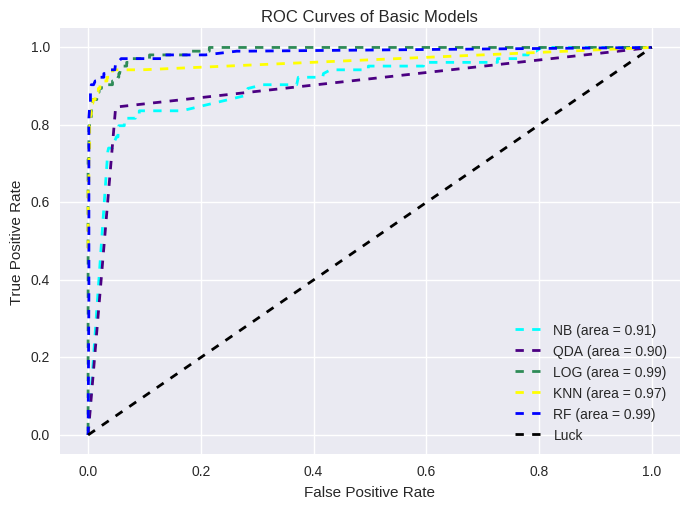

In [384]:
plt.plot(nb_fpr, nb_tpr, color='cyan', linestyle='--',
         label='NB (area = %0.2f)' % nb_roc_auc, lw=2)

plt.plot(qda_fpr, qda_tpr, color='indigo', linestyle='--',
         label='QDA (area = %0.2f)' % qda_roc_auc, lw=2)

plt.plot(log_fpr, log_tpr, color='seagreen', linestyle='--',
         label='LOG (area = %0.2f)' % log_roc_auc, lw=2)

plt.plot(knn_fpr, knn_tpr, color='yellow', linestyle='--',
         label='KNN (area = %0.2f)' % knn_roc_auc, lw=2)

plt.plot(rf_fpr, rf_tpr, color='blue', linestyle='--',
         label='RF (area = %0.2f)' % rf_roc_auc, lw=2)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
         label='Luck')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of Basic Models')
plt.legend(loc="lower right")
plt.savefig('./plots/ROC_Basic.png', bbox_inches='tight')
plt.show()

#### Estimators with Random Oversampling of Minority Class

In [385]:
nb_fpr, nb_tpr, _ = roc_curve(y_test, 
                    nb_clf_est_ros.predict_proba(X_test)[:,1])
nb_roc_auc = auc(nb_fpr, nb_tpr)

qda_fpr, qda_tpr, _ = roc_curve(y_test, 
                    qda_clf_est_ros.predict_proba(X_test)[:,1])
qda_roc_auc = auc(qda_fpr, qda_tpr)

log_fpr, log_tpr, _ = roc_curve(y_test, 
                    log_clf_est_ros.predict_proba(X_test)[:,1])
log_roc_auc = auc(log_fpr, log_tpr)

knn_fpr, knn_tpr, _ = roc_curve(y_test, 
                    knn_clf_est_ros.predict_proba(X_test)[:,1])
knn_roc_auc = auc(knn_fpr, knn_tpr)

rf_fpr, rf_tpr, _ = roc_curve(y_test, 
                    rf_clf_est_ros.predict_proba(X_test)[:,1])
rf_roc_auc = auc(rf_fpr, rf_tpr)

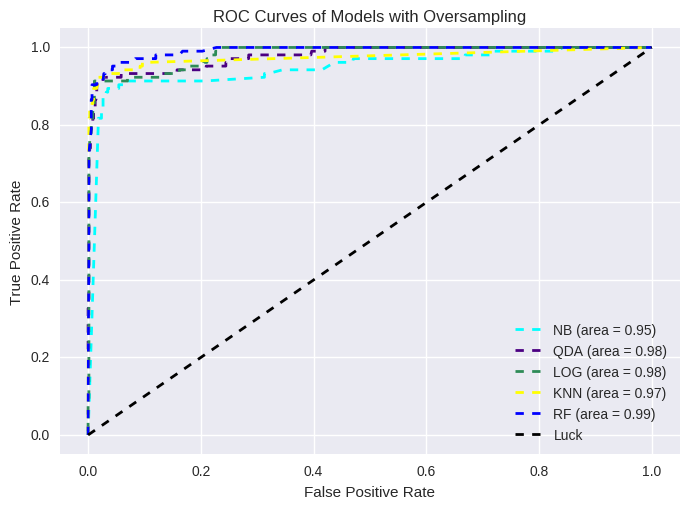

In [386]:
plt.plot(nb_fpr, nb_tpr, color='cyan', linestyle='--',
         label='NB (area = %0.2f)' % nb_roc_auc, lw=2)

plt.plot(qda_fpr, qda_tpr, color='indigo', linestyle='--',
         label='QDA (area = %0.2f)' % qda_roc_auc, lw=2)

plt.plot(log_fpr, log_tpr, color='seagreen', linestyle='--',
         label='LOG (area = %0.2f)' % log_roc_auc, lw=2)

plt.plot(knn_fpr, knn_tpr, color='yellow', linestyle='--',
         label='KNN (area = %0.2f)' % knn_roc_auc, lw=2)

plt.plot(rf_fpr, rf_tpr, color='blue', linestyle='--',
         label='RF (area = %0.2f)' % rf_roc_auc, lw=2)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
         label='Luck')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of Models with Oversampling')
plt.legend(loc="lower right")
plt.savefig('./plots/ROC_ROS.png', bbox_inches='tight')
plt.show()

Interestingly, only the basic classifiers improve in predictive performance.

#### Estimators with SMOTE

In [388]:
nb_fpr, nb_tpr, _ = roc_curve(y_test, 
                    nb_clf_est_smote.predict_proba(X_test)[:,1])
nb_roc_auc = auc(nb_fpr, nb_tpr)

qda_fpr, qda_tpr, _ = roc_curve(y_test, 
                    qda_clf_est_smote.predict_proba(X_test)[:,1])
qda_roc_auc = auc(qda_fpr, qda_tpr)

log_fpr, log_tpr, _ = roc_curve(y_test, 
                    log_clf_est_smote.predict_proba(X_test)[:,1])
log_roc_auc = auc(log_fpr, log_tpr)

knn_fpr, knn_tpr, _ = roc_curve(y_test, 
                    knn_clf_est_smote.predict_proba(X_test)[:,1])
knn_roc_auc = auc(knn_fpr, knn_tpr)

rf_fpr, rf_tpr, _ = roc_curve(y_test, 
                    rf_clf_est_smote.predict_proba(X_test)[:,1])
rf_roc_auc = auc(rf_fpr, rf_tpr)

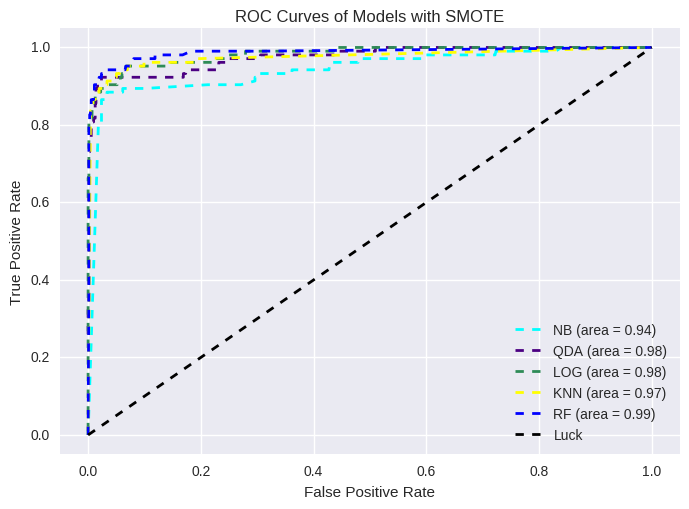

In [389]:
plt.plot(nb_fpr, nb_tpr, color='cyan', linestyle='--',
         label='NB (area = %0.2f)' % nb_roc_auc, lw=2)

plt.plot(qda_fpr, qda_tpr, color='indigo', linestyle='--',
         label='QDA (area = %0.2f)' % qda_roc_auc, lw=2)

plt.plot(log_fpr, log_tpr, color='seagreen', linestyle='--',
         label='LOG (area = %0.2f)' % log_roc_auc, lw=2)

plt.plot(knn_fpr, knn_tpr, color='yellow', linestyle='--',
         label='KNN (area = %0.2f)' % knn_roc_auc, lw=2)

plt.plot(rf_fpr, rf_tpr, color='blue', linestyle='--',
         label='RF (area = %0.2f)' % rf_roc_auc, lw=2)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
         label='Luck')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of Models with SMOTE')
plt.legend(loc="lower right")
plt.savefig('./plots/ROC_SMOTE.png', bbox_inches='tight')
plt.show()

Again, class imbalance corrections only benefit Naive Bayes and QDA.

#### Estimators with Random Undersampling of Majority Class

In [390]:
nb_fpr, nb_tpr, _ = roc_curve(y_test, 
                    nb_clf_est_rus.predict_proba(X_test)[:,1])
nb_roc_auc = auc(nb_fpr, nb_tpr)

log_fpr, log_tpr, _ = roc_curve(y_test, 
                    log_clf_est_rus.predict_proba(X_test)[:,1])
log_roc_auc = auc(log_fpr, log_tpr)

knn_fpr, knn_tpr, _ = roc_curve(y_test, 
                    knn_clf_est_rus.predict_proba(X_test)[:,1])
knn_roc_auc = auc(knn_fpr, knn_tpr)

rf_fpr, rf_tpr, _ = roc_curve(y_test, 
                    rf_clf_est_rus.predict_proba(X_test)[:,1])
rf_roc_auc = auc(rf_fpr, rf_tpr)

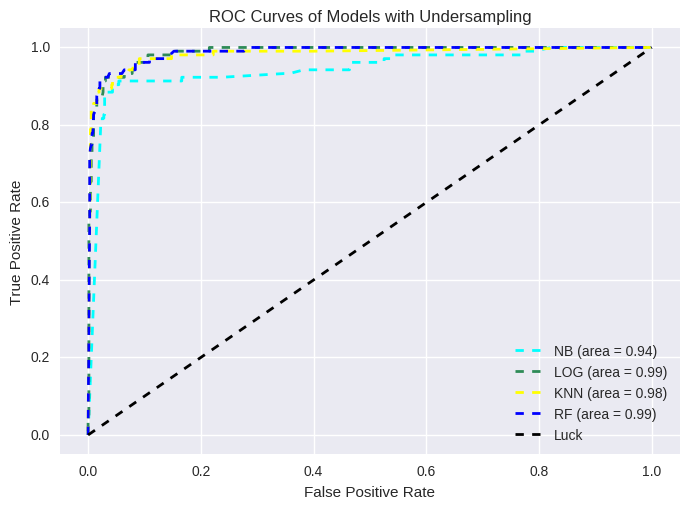

In [391]:
plt.plot(nb_fpr, nb_tpr, color='cyan', linestyle='--',
         label='NB (area = %0.2f)' % nb_roc_auc, lw=2)

plt.plot(log_fpr, log_tpr, color='seagreen', linestyle='--',
         label='LOG (area = %0.2f)' % log_roc_auc, lw=2)

plt.plot(knn_fpr, knn_tpr, color='yellow', linestyle='--',
         label='KNN (area = %0.2f)' % knn_roc_auc, lw=2)

plt.plot(rf_fpr, rf_tpr, color='blue', linestyle='--',
         label='RF (area = %0.2f)' % rf_roc_auc, lw=2)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
         label='Luck')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of Models with Undersampling')
plt.legend(loc="lower right")
plt.savefig('./plots/ROC_RUS.png', bbox_inches='tight')
plt.show()

Training QDA with undersampling resulted in errors.

#### Estimators with Tomek Link Removal

In [395]:
nb_fpr, nb_tpr, _ = roc_curve(y_test, 
                    nb_clf_est_tl.predict_proba(X_test)[:,1])
nb_roc_auc = auc(nb_fpr, nb_tpr)

qda_fpr, qda_tpr, _ = roc_curve(y_test, 
                    qda_clf_est_tl.predict_proba(X_test)[:,1])
qda_roc_auc = auc(qda_fpr, qda_tpr)

log_fpr, log_tpr, _ = roc_curve(y_test, 
                    log_clf_est_tl.predict_proba(X_test)[:,1])
log_roc_auc = auc(log_fpr, log_tpr)

knn_fpr, knn_tpr, _ = roc_curve(y_test, 
                    knn_clf_est_tl.predict_proba(X_test)[:,1])
knn_roc_auc = auc(knn_fpr, knn_tpr)

rf_fpr, rf_tpr, _ = roc_curve(y_test, 
                    rf_clf_est_tl.predict_proba(X_test)[:,1])
rf_roc_auc = auc(rf_fpr, rf_tpr)

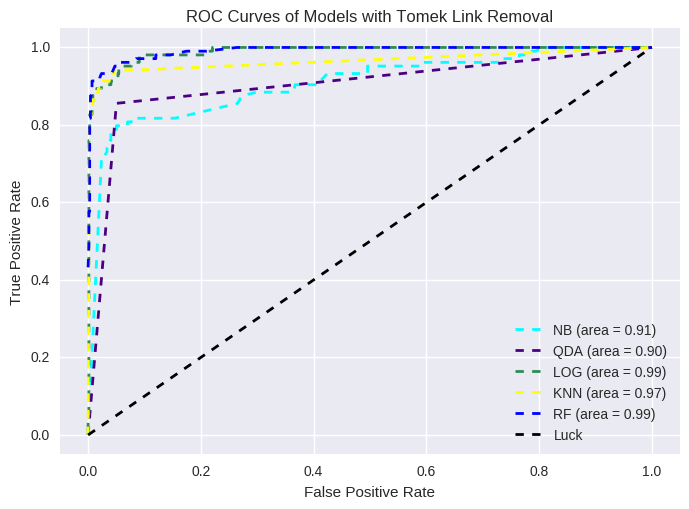

In [396]:
plt.plot(nb_fpr, nb_tpr, color='cyan', linestyle='--',
         label='NB (area = %0.2f)' % nb_roc_auc, lw=2)

plt.plot(qda_fpr, qda_tpr, color='indigo', linestyle='--',
         label='QDA (area = %0.2f)' % qda_roc_auc, lw=2)

plt.plot(log_fpr, log_tpr, color='seagreen', linestyle='--',
         label='LOG (area = %0.2f)' % log_roc_auc, lw=2)

plt.plot(knn_fpr, knn_tpr, color='yellow', linestyle='--',
         label='KNN (area = %0.2f)' % knn_roc_auc, lw=2)

plt.plot(rf_fpr, rf_tpr, color='blue', linestyle='--',
         label='RF (area = %0.2f)' % rf_roc_auc, lw=2)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
         label='Luck')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of Models with Tomek Link Removal')
plt.legend(loc="lower right")
plt.savefig('./plots/ROC_tl.png', bbox_inches='tight')
plt.show()

#### Plotting the Best of Each Classifier

In [397]:
nb_fpr, nb_tpr, _ = roc_curve(y_test, 
                    nb_clf_est_ros.predict_proba(X_test)[:,1])
nb_roc_auc = auc(nb_fpr, nb_tpr)

qda_fpr, qda_tpr, _ = roc_curve(y_test, 
                    qda_clf_est_ros.predict_proba(X_test)[:,1])
qda_roc_auc = auc(qda_fpr, qda_tpr)

log_fpr, log_tpr, _ = roc_curve(y_test, 
                    log_clf_est_b.predict_proba(X_test)[:,1])
log_roc_auc = auc(log_fpr, log_tpr)

knn_fpr, knn_tpr, _ = roc_curve(y_test, 
                    knn_clf_est_rus.predict_proba(X_test)[:,1])
knn_roc_auc = auc(knn_fpr, knn_tpr)

rf_fpr, rf_tpr, _ = roc_curve(y_test, 
                    rf_clf_est_b.predict_proba(X_test)[:,1])
rf_roc_auc = auc(rf_fpr, rf_tpr)

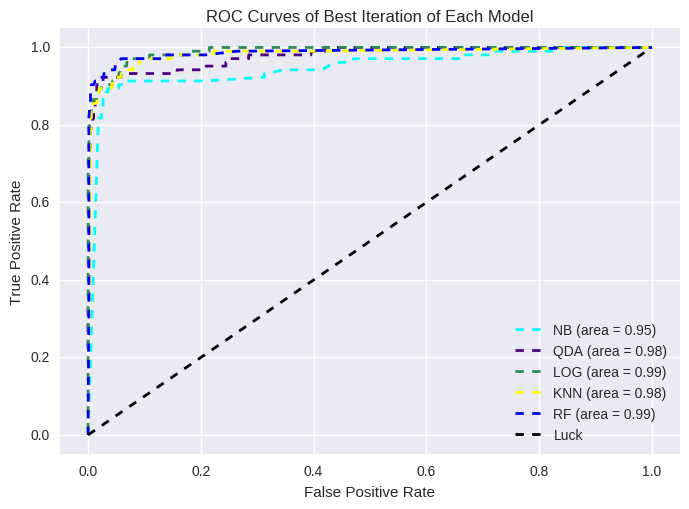

In [398]:
plt.plot(nb_fpr, nb_tpr, color='cyan', linestyle='--',
         label='NB (area = %0.2f)' % nb_roc_auc, lw=2)

plt.plot(qda_fpr, qda_tpr, color='indigo', linestyle='--',
         label='QDA (area = %0.2f)' % qda_roc_auc, lw=2)

plt.plot(log_fpr, log_tpr, color='seagreen', linestyle='--',
         label='LOG (area = %0.2f)' % log_roc_auc, lw=2)

plt.plot(knn_fpr, knn_tpr, color='yellow', linestyle='--',
         label='KNN (area = %0.2f)' % knn_roc_auc, lw=2)

plt.plot(rf_fpr, rf_tpr, color='blue', linestyle='--',
         label='RF (area = %0.2f)' % rf_roc_auc, lw=2)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
         label='Luck')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of Best Iteration of Each Model')
plt.legend(loc="lower right")
plt.savefig('./plots/ROC_Best.png', bbox_inches='tight')
plt.show()

### Inspecting the Best Classifier

While best model performs extremely well. It is important to be aware of model characteristics like the variability of prediction quality, a key model reliability metric, and the important features, which should inform data maintenance and engineering practices as a model interpretation.  

#### Variability of Prediction Quality

Normally I would use bootstrapped samples of the test data, with the model fitted on the whole training data, to obtain an empirical distribution of the model's performance (AUC ROC in this case). However, with limited data and time, I will use the AUC ROC on the validation folds of the CV grid search to get a sense of the variability. Normally the AUC ROC values will be biased towards optimism compared to the true out of sample performance.

In [337]:
log_cv_results=pd.DataFrame(log_clf_est_b.cv_results_)
log_cv_results.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__C,param_clf__class_weight,param_vt__threshold,params,rank_test_score,split0_test_score,...,split7_test_score,split7_train_score,split8_test_score,split8_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.293604,0.021845,0.962189,0.967970,0.001,balanced,0,"{'clf__class_weight': 'balanced', 'clf__C': 0....",16,0.945366,...,0.958231,0.968744,0.946803,0.968351,0.958503,0.968571,0.054329,0.017037,0.012848,0.001090
1,0.107706,0.002611,0.907534,0.916955,0.001,balanced,0.0475,"{'clf__class_weight': 'balanced', 'clf__C': 0....",36,0.911927,...,0.882585,0.917638,0.886871,0.907333,0.901293,0.941246,0.033600,0.001434,0.016534,0.012809
2,0.101349,0.003126,0.834614,0.842298,0.001,balanced,0.09,"{'clf__class_weight': 'balanced', 'clf__C': 0....",56,0.820761,...,0.780544,0.849960,0.768095,0.846585,0.877347,0.838907,0.030489,0.002562,0.040203,0.004708
3,0.118987,0.002824,0.813992,0.817461,0.001,balanced,0.1275,"{'clf__class_weight': 'balanced', 'clf__C': 0....",73,0.792588,...,0.772517,0.831389,0.738163,0.821732,0.840680,0.811150,0.024047,0.001378,0.044496,0.005895
4,0.338856,0.015122,0.882875,0.892010,0.001,{1: 1},0,"{'clf__class_weight': {1: 1}, 'clf__C': 0.001,...",38,0.896524,...,0.884490,0.891744,0.823265,0.897401,0.888571,0.891773,0.116151,0.011178,0.027455,0.002772


Isolate the best parameters

In [338]:
log_cv_results=log_cv_results[(log_cv_results.rank_test_score==1)]
log_cv_results.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__C,param_clf__class_weight,param_vt__threshold,params,rank_test_score,split0_test_score,...,split7_test_score,split7_train_score,split8_test_score,split8_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
36,0.32326,0.011403,0.976376,0.999047,10,{1: 1},0,"{'clf__class_weight': {1: 1}, 'clf__C': 10, 'v...",1,0.964192,...,0.964898,0.999232,0.976054,0.999008,0.992381,0.998826,0.041042,0.005302,0.011016,0.00027


In [339]:
keep_cols=["split"+str(i)+"_test_score" for i in range(0,10)]
log_cv_results=log_cv_results[keep_cols]
log_cv_results.head()
temp=log_cv_results.T.reset_index()
temp.columns=['Fold','Validation AUC ROC']best_estimator_.classes_
temp['Fold']=range(1,11)
temp

,Fold,Validation AUC ROC
0,1,0.964192
1,2,0.988283
2,3,0.962744
3,4,0.983676
4,5,0.983598
5,6,0.984762
6,7,0.963197
7,8,0.964898
8,9,0.976054
9,10,0.992381


In [340]:
temp['Validation AUC ROC'].describe()

count    10.000000
mean      0.976378
std       0.011612
min       0.962744
25%       0.964368
50%       0.979826
75%       0.984490
max       0.992381
Name: Validation AUC ROC, dtype: float64

Fortunately, the performance is stable. With more data and time, I would do repeat cross-validation or repeated nested cross-validation to get more robust estimates of the out of sample error and its variability.

#### Important features

Unfortunately, even on a standardized scale, coefficient magnitude is not necessarily the right way to determine variable importance in a logistic regression. Fortunately, the random forest classifier has similar performance to the logistic regression, so it will use it to identify important features. 

In [355]:
rf_clf_b.set_params(**rf_clf_est_b.best_params_).fit(X_train,y_train)

Pipeline(steps=[('vt', VarianceThreshold(threshold=0)), ('clf', RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features=0.1,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [375]:
importance=rf_clf_b.named_steps['clf'].feature_importances_
indices = np.argsort(importance)[::-1]

In [376]:
feature_importance=pd.DataFrame({'feature':clean_data.columns[:-1][indices],
                                 'importance':importance})

In [380]:
feature_importance.sort_values(by='importance',inplace=True,ascending=False)
feature_importance[:10]

,feature,importance
16,ancurl*adclick,0.128013
22,ancurl*adid,0.069461
372,origurl*misfits2,0.064269
1420,url*static.wired.com,0.043636
8,ancurl*http+www,0.043488
1264,origurl*lofts,0.043221
1504,url*off+gif,0.024394
1476,ancurl*www.amazon.com,0.021361
1250,url*alley,0.021211
1299,origurl*www.sanjosesabercats.com,0.018702


It is not surprising that the most important two features are ad attributes. This also adds confidence to the model by showing that it is picking up reasonable features in the data. 

Many of the other top ten features, like url*static.wired.com and ancurl*www.amazon.com, also make sense because they are likely links to the urls of the companying that owns the ad.

I would not be surprised if adding random forest as a feature selection step in the pipeline wouldn't bring the AUC ROC of nearly all of the classifiers to 0.99. 

### Final Thoughts

The best model is clearly the logistic classifier without the sampling-based class imbalance corrections. While the random forest mirrors its performance, the random forest is a much more complex and computationally expensive model. Therefore, in practice, the logistic classifier would be best. 

It is surprising that the class imbalance corrections had limited impact on the more complex classifiers. In other classification tasks, the class imbalance corrections, especially the Tomek Link removals, significantly improved the AUC ROC of the more complex classifiers. However every classification task is different.

If the AUC ROC was not already 0.99, I would try feature selection via random forest, ensemble methods other than random forest like bagging classifiers, adaptive boosting, or even extreme gradient boosting or do more aggressive feature engineering and hyperparameter tuning. However at an AUC ROC of 0.99, this is definitely not a good investment of company time.

#### Saving parameters of final model

In [240]:
best_paras = log_clf_est_b.best_params_
best_paras

{'clf__C': 10, 'clf__class_weight': {1: 1}, 'vt__threshold': 0}

In [241]:
with open('./model_para/logistic_best_paras.json', 'w') as outfile:
    json.dump(best_paras, outfile)